# Markov Chain Monte Carlo

## Recap

We have some target function (the likelihood times the prior) in some parameter space, and we want to integrate it.

As a toy example, we chose the following likelihood:

In [1]:
def loglikelihood(*parameters):
    a = np.asarray(parameters)[:-1] * 10
    b = np.asarray(parameters)[1:] * 10
    return -2 * (100 * (b - a**2)**2 + (1 - a)**2).sum()

And we assume our prior is uniform in the domain -1/2 to +1/2 in each parameter. 
We use two parameters at the moment.

In [2]:
lo = -0.5
hi = 0.5
dim = 2

Lets plot this function in 2d:

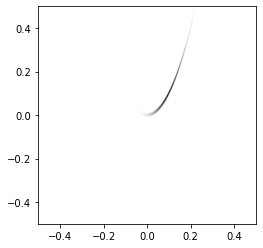

In [3]:
import numpy as np
import matplotlib.pyplot as plt

a = np.linspace(lo, hi, 400)
b = np.linspace(lo, hi, 400)

# TODO by you!

grid = np.meshgrid(a, b)
grid_unnormalised_logposterior = np.vectorize(loglikelihood)(grid[0], grid[1])

plt.imshow(
      np.exp(grid_unnormalised_logposterior[::-1]),
      extent=(lo, hi, lo, hi),
      aspect='equal', cmap='gray_r');

## Markov Chain Monte Carlo intro

In importance sampling, we used uncorrelated points. 

### Important terminology

Now we use an algorithm which produces a sequence of points: $\theta_1,\theta_2,...\theta_N$. We call this a **chain**.

A sequence of points where the next point **only** depends on the immediately previous point and not on earlier points is called a **Markov Chain**. We say the chain has a Markov property.

![Markov Chain](img/chain.png)

If the distribution of chain points approximates the target distribution, we call the chain **converged**. This may require very long chains. Important technical terms are **stationarity** and **ergodicity**: stationary processes do not shift over time. 
Ergodicity is if the distribution within a long chain is the same as one random point taken from many chains.
![Stationary](img/stationary.png)
![Ergodicity](img/ergodicity.jpg)


Because the algorithm will produce use random numbers to generate the next point in the Markov Chain (a Monte Carlo algorithm), it is a **Markov Chain Monte Carlo** (MCMC) algorithm.

The transition from one point to the next is called a **transition kernel**: $P(\theta_{i+1}|\theta_i)$. Each transition kernel gives a subclass of MCMC algorithms.

Here we will focus on transition kernels based on a **Gaussian random walk**:

$\theta_{proposed} \sim Normal(\theta_i, \sigma)$:

In words, the next point is suggested by a Gaussian draw around the current point.

![Gaussian proposal](img/gaussian-proposal.jpg)


In [20]:
mychain = [[0, 0]]
proposal_sigma = 0.001

In [21]:
previous_point = mychain[-1]
proposed_point = np.random.normal(previous_point, proposal_sigma)

The final ingredient is the acceptance rule, to decide whether we stay with the current point or accept the proposed point. The rule is very simple and says:

*We accept with a probability $\alpha$, which is the target probability ratio of the current to the proposed point*:

$\alpha = p_\mathrm{accept} = \frac{f(\theta')}{f(\theta)}$

This means there are three scenarios:

* The proposed point $\theta'$ has a much, much lower probability than $\theta$ -> stay
* The proposed point $\theta'$ has a higher or equal probability than $\theta$ -> accept
* The proposed point $\theta'$ has a slightly lower probability than $\theta$ -> there is a chance we will accept.

This is called the **Metropolis algorithm**. There is also an extension, the Metropolis-Hasting algorithm, for asymmetric transition kernels.

Lets implement our update rule:

In [22]:
def metropolis_algorithm(theta_new, theta_old):
    # TODO by you:
    prob_new = # call loglikelihood using *theta_new, and convert to linear from ln
    prob_old = # call loglikelihood using *theta_old, and convert to linear from ln
    
    alpha = # take the ratio between prob_new and prob_old
    
    # draw randomly proportional to prob_ratio
    u = np.random.uniform()
    if u < alpha:
        return True
    else:
        return False

In [23]:
Niter = 10000
Naccepts = 0

for i in range(Niter):

    # get last point added to the chain
    previous_point = mychain[-1]

    # pick a proposed point
    proposed_point = np.random.normal(previous_point, proposal_sigma)

    # do we accept this point?
    if metropolis_algorithm(proposed_point, previous_point):
        Naccepts += 1
        next_point = proposed_point
    else:
        next_point = previous_point

    mychain.append(next_point)


Lets already go ahead and make several chains, so we get a better feel for the typical behaviour:

In [24]:
def mcmc(starting_point, Niter, proposal_sigma):
    Naccepts = 0
    chain = [starting_point]

    for i in range(Niter):

        previous_point = chain[-1]

        proposed_point = np.random.normal(previous_point, proposal_sigma)

        # do we accept this point?
        if metropolis_algorithm(proposed_point, previous_point):
            Naccepts += 1
            next_point = proposed_point
        else:
            next_point = previous_point

        chain.append(next_point)

    return Naccepts, chain

In [25]:
chains_results = [mcmc(starting_point=[0, 0], Niter=10000, proposal_sigma=0.001) for i in range(4)]

Lets see how often the proposal was accepted, and a transition was made:

In [26]:
print("acceptance rates: " + ', '.join(['%.1f%%' % (100 * Naccepts / len(chain)) for Naccepts, chain in chains_results]))

acceptance rates: 90.8%, 89.7%, 91.8%, 92.1%


As a rule of thumb for Metropolis MCMC:

* 23% is ideal (unless in very low dimensions)
* \>50% indicates the proposal is too small and the algorithm performs a levy-flight.
* 0% indicates the chain is stuck: The proposal is too wide and does not find good nearby points.


In [27]:
chains = np.asarray([chain for Naccepts, chain in chains_results])

# Visualisations

## 2d: conditional probability distribution

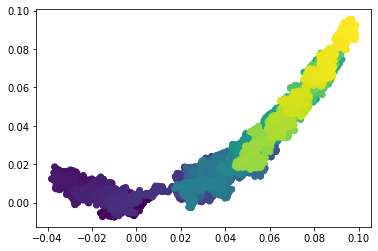

In [28]:
plt.scatter(
            np.asarray(chains[0])[:,0],
            np.asarray(chains[0])[:,1],
            c=np.arange(len(chains[0])),
);

### Trace plots

For each parameter, plot iteration vs value:

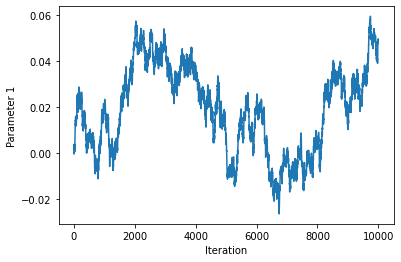

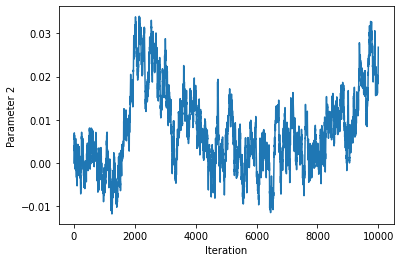

In [29]:
for i in range(dim):
    plt.figure()

    # TODO by you: plot all four chains instead of mychain
    plt.plot(np.asarray(mychain)[:,i])
    
    plt.ylabel("Parameter %d" % (i+1))
    plt.xlabel("Iteration");

### Marginal probability distribution

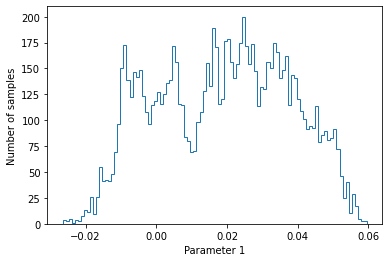

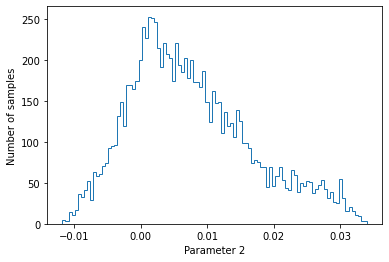

In [30]:
for i in range(dim):
    plt.figure()

    # TODO by you: plot all four chains instead of mychain
    plt.hist(np.asarray(mychain)[:,i], bins=100, histtype='step')

    plt.xlabel("Parameter %d" % (i+1))
    plt.ylabel("Number of samples")


# Evaluation

The trace plots show clearly that there is correlation between points.

Points are not independent, but **correlated**.

We can see this by splitting the chain into chunks:

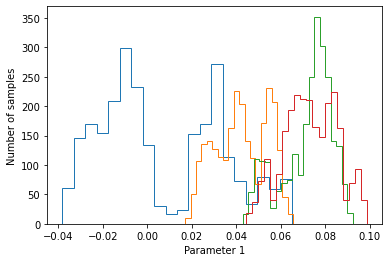

In [31]:
for i in [0]:
    plt.figure()
    chain = chains[0]
    chain_chunks = np.array_split(chain, 4)
    for chunk in chain_chunks:
        plt.hist(chunk[:,i], bins=20, histtype='step')
    plt.xlabel("Parameter %d" % (i+1))
    plt.ylabel("Number of samples")


If the histograms are quite different between chunks, the chain has not converged. 

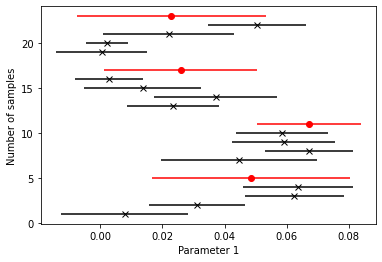

In [32]:
j = 0

for i in [0]:
    plt.figure()
    for chain in chains:
        chain_chunks = np.array_split(chain, 4)
        for chunk in chain_chunks:
            plt.errorbar(x=chunk.mean(), xerr=chunk.std(), y=j + 1, marker='x', color='k')
            j += 1
        plt.errorbar(x=chain[:,i].mean(), xerr=chain[:,i].std(), y=j + 1, marker='o', color='r')
        j += 2
    
    plt.xlabel("Parameter %d" % (i+1))
    plt.ylabel("Number of samples")


Ideally, we want all of the markers (x and o) to line up.

We can quantify this by comparing the variance of the means within the chunks and across chains:

* Let $W$ be the average of the chunk variances
* Let $M_i$ be the mean in chain i, and $M$ the overall mean
* Let $B$ be the variance of M_ij: $B=\frac{1}{m-1}\sum_{i=1}^m (M_i - M)^2$
* Let $\hat{R} \approx \sqrt{1 + B/W}$

If the variances within each chain and the variances across chains are the same (W=B), then $\hat{R}=1$.

Deviations from 1 (e.g., \>1.01) are a sign that the chain has not converged.

![Variance within a chain](img/variance-within-chain.png)

![Variance between chains](img/variance-between-chains.png)


In [33]:
j = 0

for i in range(dim):
    mean = np.mean(chains[:,:,i])

    chunk_variances = []
    
    chain_variances = []
    for chain in chains:
        chain_variances.append(np.var(chain[:,i]))
        chain_chunks = np.array_split(chain, 4)
        for chunk in chain_chunks:
            chunk_variances.append( ((chunk[:,i].mean() - mean)**2))
    
    W = np.mean(chain_variances)
    B = sum(chunk_variances) / (len(chunk_variances) - 1)
    
    print("B:", B, "W:", B)
    print("Rhat for Parameter %d: %.2f" % (i, np.sqrt(1+B/W)))
    print()

B: 0.0008095890333402604 W: 0.0008095890333402604
Rhat for Parameter 0: 1.46

B: 0.00042548763439751927 W: 0.00042548763439751927
Rhat for Parameter 1: 1.49



## Exercise 1 (30 points)

* Play with the number of MCMC iterations and the proposal standard deviation.

* Observe the trace plots. What do you notice? Can you make Rhat=1?

* Plot the Niter needed so that Rhat becomes <1.01, for different values of sigma (0.1, 0.04, 0.01, 0.004).

* Plot Niter vs acceptance rate.

## Exercise 2 (10 points)

Try starting the chain at a random location in prior space.

The algorithm we used works in probabilities, but has numerical problems when they become smaller than 1e-330.

--> Rewrite the MCMC algorithm to work with logarithmic probabilities only (never using exp).

## Homework exercise 1 (20 points)

Find the [auto-correlation length](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) of one of the chains.

Measure the effective sample size by dividing the number of samples by the auto-correlation length.


## Questions

Related to efficiency:
* What have you learned about the proposal distribution and auto-correlation?
* Will a small proposal size give higher or lower correlation between points?
* What proposal shape and size would be most efficient?

Related to using the output of MCMC algorithms:
* How would you use the marginal histograms to get parameter uncertainties?
* If the chain is not converged, what would a user of a single chain conclude about the credible interval? What could go wrong?
* How did we compute the Bayesian evidence (normalising factor)?
* Is convergence defined for the chain globally, or for each parameter?


## Homework exercise 2 (60 points)

Set up a target density which sums two Gaussians:

$f(\theta)=\mathrm{NormalPDF}(\theta|\mu=-\Delta,\sigma=1) + \mathrm{NormalPDF}(\theta|\mu=+\Delta,\sigma=1).$

Plot $\Delta$ vs the number of iterations needed for convergence, for 2d and 20d.

Starting the chains at random locations.


## Further reading

MCMC is a very mature field and its algorithmic variants have been studied for >50 years.

There are lots of resources (slides, papers, tutorials) online, just search for "intro/tutorial to MCMC".

Gaussian Random Walk Metropolis MCMC is quite inefficient in moderate dimensions (>5), even with optimally adapted proposals.

Important MCMC variants:

* Gibbs sampling: analytic conditional distributions allow 100% efficient updates of one parameter.
* Slice sampling
* Simulated tempering, Parallel tempering: make chain easier to navigate by suppressing the likelihod $L^{\beta}, \beta=0...1$.
* Ensemble updates: Maintain several walkers (chains) and update them all
  * Differential Evolution MCMC
  * Goodman Weare, aka, Affine-Invariant Ensemble sampler
     * [emcee](https://emcee.readthedocs.io/) implementation extremely popular in astronomy
     * Sensitive to initialisation, two tuning parameters: number of walkers and gamma.
     * Beware of bad behaviour in high-d: https://arxiv.org/abs/1509.02230
  * Ensemble Slice Sampling (zeus)
     * [zeus](https://zeus-mcmc.readthedocs.io/) implementation, similar use as emcee
* Reversible Jump MCMC: allows varying dimensionality. Difficult to work with.
* Hamiltonian Monte Carlo: Uses likelihood gradients to make trajectories. Efficient in high dimensions.

Diagnostics:

* https://arviz-devs.github.io/arviz/
* CODA R package
* state-of-the-art R-hat paper: https://arxiv.org/abs/1903.08008

Conceptual introduction: https://arxiv.org/pdf/1701.02434.pdf

